In [1]:
import os
import random
import itertools
from random import shuffle
import h5py
import json
import tensorflow as tf

import numpy as np
import scipy
import scipy.io as sio # Scipy input and output
import scipy.ndimage 
from skimage.transform import rotate 
import spectral # Module for processing hyperspectral image data.
import matplotlib 
%matplotlib inline

# scikit-learn imports 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

# keras imports 
#import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import sys
import pathlib
import spectral
import math
import tensorflow as tf

In [2]:
### Limit GPU Memory growth ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# for i in [bar_2013, bar_2014, bar_ch_gt, hermi_2004, hermi_2007, hermi_ch_gt, bay_2013, bay_2015, bay_ch_gt_2, bay_ch_gt_ol, river_before, river_after, river_ch_gt, data1_2009, data1_2015, data1_ch_gt, data2_2009, data2_2015]:
#     print("List of dictionary keys: ")
#     key = list(i.keys());
#     print(key);
#     print("List of dictionary values")
#     for j in range(len(key) - 1):
#          print(i[key[j]])

In [4]:
bar_2013 = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\barbara_2013.mat")["HypeRvieW"]
bar_2014 = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\barbara_2014.mat")["HypeRvieW"]
bar_ch_gt = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\barbara_gtChanges.mat")["HypeRvieW"]
hermi_2004 = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\hermiston2004.mat")["HypeRvieW"]
hermi_2007 = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\hermiston2007.mat")["HypeRvieW"]
hermi_ch_gt = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\Hermiston_rdChangesHermiston_5classes.mat")["gt5clasesHermiston"]
# bay_2013 = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\Bay_Area_2013.mat")["HypeRvieW"]
# bay_2015 = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\Bay_Area_2015.mat")["HypeRvieW"]
# #bay_ch_gt_1 = sio.loadmat(r"E:\bayArea_gtChanges.mat")
# bay_ch_gt_2 = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\bayArea_gtChanges2.mat")['HypeRvieW']
# bay_ch_gt_ol = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\bayArea_gtChangesolf.mat")['HypeRvieW']
# river_before = sio.loadmat(r"C:\Users\CVR 2019 2020\hyperspectral_custom\Change-Detection-in-Hyperspectral-Images\Dataset\river_before.mat")['river_before']
# river_after = sio.loadmat(r"C:\Users\CVR 2019 2020\hyperspectral_custom\Change-Detection-in-Hyperspectral-Images\Dataset\river_after.mat")['river_after']
# river_ch_gt = sio.loadmat(r"C:\Users\CVR 2019 2020\hyperspectral_custom\Change-Detection-in-Hyperspectral-Images\Dataset\groundtruth.mat")['lakelabel_v1']

# data1_2009 = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\Dataset#1_2009.mat")['Data2009']
# data1_2015 = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\Dataset#1_2015.mat")['Data2015']
# data1_ch_gt = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\Dataset#1_GT.mat")['GT_end']
# data2_2009 = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\Dataset#2_2009.mat")["Data2009"]
# data2_2015 = sio.loadmat(r"E:\Hyperspectral Image Datasets\change_detec\Dataset#2_2015.mat")["Data2015"]

In [5]:
u = 0;
for i in [bar_2013, bar_2014, bar_ch_gt, hermi_2004, hermi_2007, hermi_ch_gt]:
    print("Size of entry ", u, ": ");
    print(i.shape)
    u = u+1;

Size of entry  0 : 
(984, 740, 224)
Size of entry  1 : 
(984, 740, 224)
Size of entry  2 : 
(984, 740)
Size of entry  3 : 
(390, 200, 242)
Size of entry  4 : 
(390, 200, 242)
Size of entry  5 : 
(390, 200)


In [6]:
for i in [bar_ch_gt, hermi_ch_gt]:
    print("Unique Elements and their counts in entry ", u, ": ");
    print(np.unique(i, return_counts=True))
    u = u+1;

Unique Elements and their counts in entry  6 : 
(array([0, 1, 2], dtype=uint8), array([595608,  52134,  80418], dtype=int64))
Unique Elements and their counts in entry  7 : 
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([68014,  5558,  1331,    79,  1557,  1461], dtype=int64))


c:\users\cvr 2019 2020\anaconda3\envs\tf2\lib\site-packages\spectral\graphics\spypylab.py:27: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams['keymap.all_axes'] = ''
c:\users\cvr 2019 2020\anaconda3\envs\tf2\lib\site-packages\spectral\graphics\spypylab.py:905: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  self.class_axes = plt.imshow(self.class_rgb, **kwargs)


ImageView object:
  Interpolation       :  <default>

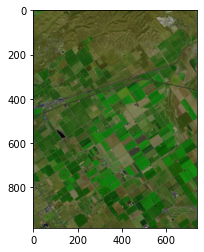

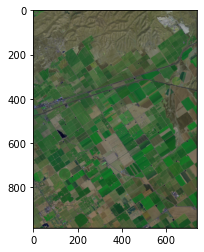

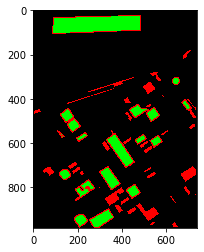

In [7]:
spectral.imshow(bar_2013, bands=[120, 100, 22])
spectral.imshow(bar_2014, bands=[120, 100, 22])
spectral.imshow(classes=bar_ch_gt)

ImageView object:
  Interpolation       :  <default>

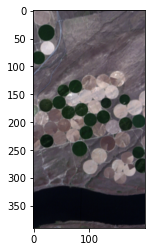

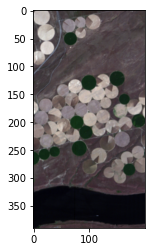

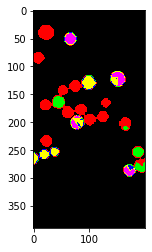

In [8]:
spectral.imshow(hermi_2004, bands=[29, 19, 12])
spectral.imshow(hermi_2007, bands=[29, 19, 12])
spectral.imshow(classes=hermi_ch_gt)

## Min-max normalization ##

In [9]:
bar_2013_re = ((bar_2013 - bar_2013.min()) / (bar_2013.max() - bar_2013.min()))
bar_2014_re = ((bar_2014 - bar_2014.min()) / (bar_2014.max() - bar_2014.min()))
hermi_2004_re = ((hermi_2004 - hermi_2004.min()) / (hermi_2004.max() - hermi_2004.min()))
hermi_2007_re = ((hermi_2007 - hermi_2007.min()) / (hermi_2007.max() - hermi_2007.min()))

In [10]:
del bar_2013
del bar_2014
del hermi_2004
del hermi_2007

In [11]:
def pad_with_zeros(X, margin_x, margin_y):
    """apply zero padding to X with margin only the end of the rows and cols"""
    
    new_X = np.zeros(((X.shape[0] + margin_x), (X.shape[1] + margin_y), X.shape[2]))
    new_X[:X.shape[0], :X.shape[1], :] = X
    return new_X

In [12]:
def pad_gt_zeros(X, margin_x, margin_y):
    """apply zero padding to X with margin only the end of the rows and cols"""
    
    new_X = np.zeros(((X.shape[0] + margin_x), (X.shape[1] + margin_y)))
    new_X[:X.shape[0], :X.shape[1]] = X
    return new_X

In [13]:
def save_cat_patches(paths, name, array, stride):
    x_steps = math.ceil(((array.shape[0]-64)/stride)+1); #Total number of steps by patches without losing anything
    y_steps = math.ceil(((array.shape[1]-64)/stride)+1); #Total number of steps by patches without losing anything
    margin_x = ((stride * (x_steps-1))+64) - array.shape[0] + 1; # Plus one extra space is required 
    margin_y = ((stride * (y_steps-1))+64) - array.shape[1] + 1; # Plus one extra space is required 
    if (len(array.shape) > 2): padded = pad_with_zeros(array, margin_x, margin_y)
    else: padded = pad_gt_zeros(array, margin_x, margin_y)
    padded = tf.keras.utils.to_categorical(padded, num_classes=np.unique(array).shape[0])
    print(padded.shape)
    counter = 0;
    for r in range(0, padded.shape[0]-64, stride):#r is row       
        for c in range(0, padded.shape[1]-64, stride):#c is col 
            patch = padded[r:r+64, c:c+64];
            np.save(pathlib.Path(paths, '{:04d}'.format(counter)).with_suffix(".npy"), patch);
            counter= counter+1;

In [14]:
def save_final_patches(paths, name, array, stride):
    x_steps = math.ceil(((array.shape[0]-64)/stride)+1); #Total number of steps by patches without losing anything
    y_steps = math.ceil(((array.shape[1]-64)/stride)+1); #Total number of steps by patches without losing anything
    margin_x = ((stride * (x_steps-1))+64) - array.shape[0] + 1; # Plus one extra space is required 
    margin_y = ((stride * (y_steps-1))+64) - array.shape[1] + 1; # Plus one extra space is required 
    if (len(array.shape) > 2): padded = pad_with_zeros(array, margin_x, margin_y)
    else: padded = pad_gt_zeros(array, margin_x, margin_y)
    print(padded.shape)
    counter = 0;
    for r in range(0, padded.shape[0]-64, stride):#r is row       
        for c in range(0, padded.shape[1]-64, stride):#c is col 
            patch = padded[r:r+64, c:c+64];
            np.save(pathlib.Path(paths, '{:04d}'.format(counter)).with_suffix(".npy"), patch);
            counter= counter+1;

### Save Hermiston 2004 and 2007 patches - with stride 5 and 64

In [15]:
save_final_patches(r"E:\intermediate_notebooks\hermi2004", "hermi_2004", hermi_2004_re, 5)
save_final_patches(r"E:\intermediate_notebooks\hermi2004_final", "hermi_2004", hermi_2004_re, 64) 

(395, 205, 242)
(449, 257, 242)


In [16]:
save_final_patches(r"E:\intermediate_notebooks\hermi2007", "hermi_2007", hermi_2007_re, 5)
save_final_patches(r"E:\intermediate_notebooks\hermi2007_final", "hermi_2007", hermi_2007_re, 64) 

(395, 205, 242)
(449, 257, 242)


In [17]:
save_cat_patches(r"E:\intermediate_notebooks\hermi_ch_gt_cat", "hermi_ch_gt_cat", hermi_ch_gt, 5)
save_cat_patches(r"E:\intermediate_notebooks\hermi_ch_gt_cat_final", "hermi_ch_gt_cat", hermi_ch_gt, 64)
save_final_patches(r"E:\intermediate_notebooks\hermi_ch_gt_final", "hermi_ch_gt", hermi_ch_gt, 64)

(395, 205, 6)
(449, 257, 6)
(449, 257)


### Save Barbara 2013 and 2014 patches - with stride 20 and 64

In [18]:
save_final_patches(r"E:\intermediate_notebooks\bar2013", "bar2013", bar_2013_re, 20)
save_final_patches(r"E:\intermediate_notebooks\bar2013_final", "bar2013", bar_2013_re, 64) 

(985, 745, 224)
(1025, 769, 224)


In [19]:
save_final_patches(r"E:\intermediate_notebooks\bar2014", "bar2014", bar_2014_re, 20)
save_final_patches(r"E:\intermediate_notebooks\bar2014_final", "bar2014", bar_2014_re, 64) 

(985, 745, 224)
(1025, 769, 224)


In [20]:
save_cat_patches(r"E:\intermediate_notebooks\bar_ch_gt_cat", "bar_ch_gt_cat", bar_ch_gt, 20)
save_cat_patches(r"E:\intermediate_notebooks\bar_ch_gt_cat_final", "bar_ch_gt_cat", bar_ch_gt, 64)
save_final_patches(r"E:\intermediate_notebooks\bar_ch_gt_final", "bar_ch_gt", bar_ch_gt, 64)

(985, 745, 3)
(1025, 769, 3)
(1025, 769)


## Create patches from two images ##

In [21]:
def save_differing_patches(paths, name, array1, array2, stride):
    x_steps = math.ceil(((array1.shape[0]-64)/stride)+1); #Total number of steps by patches without losing anything
    y_steps = math.ceil(((array1.shape[1]-64)/stride)+1); #Total number of steps by patches without losing anything
    margin_x = ((stride * (x_steps-1))+64) - array1.shape[0] + 1; # Plus one extra space is required 
    margin_y = ((stride * (y_steps-1))+64) - array1.shape[1] + 1; # Plus one extra space is required 
    if (len(array1.shape) > 2): 
        padded1 = pad_with_zeros(array1, margin_x, margin_y)
        padded2 = pad_with_zeros(array2, margin_x, margin_y)
        print("Received HSI cube!")
    else: padded = pad_gt_zeros(array, margin_x, margin_y)
    print(padded1.shape)
    print(padded2.shape)
    counter = 0;
    for r in range(0, padded1.shape[0]-64, stride):#r is row       
        for c in range(0, padded1.shape[1]-64, stride):#c is col 
            patch1 = padded1[r:r+64, c:c+64];
            patch2 = padded2[r:r+64, c:c+64];
            np.save(pathlib.Path(paths, '{:04d}'.format(counter)).with_suffix(".npy"), patch1);
            counter= counter+1;
            np.save(pathlib.Path(paths, '{:04d}'.format(counter)).with_suffix(".npy"), patch2);
            counter= counter+1;

In [22]:
save_differing_patches(r"E:\intermediate_notebooks\hermi_combined", "hermi_combined", hermi_2004_re, hermi_2007_re, 8)

Received HSI cube!
(393, 201, 242)
(393, 201, 242)


In [23]:
save_differing_patches(r"E:\intermediate_notebooks\bar_combined", "hermi_combined", bar_2013_re, bar_2014_re, 30)

Received HSI cube!
(995, 755, 224)
(995, 755, 224)
